In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore")


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam

import seaborn as sns
import random
import csv

from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler


In [2]:
import numpy as np
import pandas as pd
import pmdarima as pm
from pmdarima import utils
from pmdarima import arima
from pmdarima import model_selection
from tensorflow.keras.layers import LSTM

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from matplotlib import pyplot as plt

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU, PReLU
from keras_tuner.tuners import RandomSearch

from sklearn.metrics import mean_absolute_percentage_error

Using TensorFlow backend


In [4]:
df=pd.read_csv('icecream_sales_date 2009-2022.csv', index_col='date', parse_dates=True,encoding="utf-8")
df.head()

,sales,tokyo_temperature,holiday,Unnamed: 4,temperature_difference_2009_2018,temperature_difference_2019_2021,Unnamed: 7,2009,2010,2011,...,2015,2016,2017,2018,2019,2020,2021,2022,AVERAGE2009-2018,AVERAGE2019-2021
date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,17.59,10.6,1,NaN,0.521429,0.033333,1.0,10.2,11.0,9.1,...,10.4,10.6,10.8,9.4,10.3,11.1,10.3,9.4,10.078571,10.566667
2009-01-02,23.83,11.6,1,NaN,1.521429,1.033333,2.0,11.5,9.9,11.2,...,10.4,12.2,12.1,10.1,11.6,13.3,14.0,10.5,11.142857,12.966667
2009-01-03,22.94,10.7,1,NaN,0.621429,0.133333,3.0,13.7,13.2,12.3,...,15.5,14.9,13.4,16.9,15.4,16.0,17.9,16.6,14.942857,16.433333
2009-01-04,17.14,11.1,1,NaN,1.021429,0.533333,4.0,20.2,16.6,18.9,...,19.3,20.3,19.9,22.1,19.0,18.2,20.6,20.2,19.471429,19.266667
2009-01-05,10.32,11.8,0,NaN,1.721429,1.233333,5.0,23.6,23.0,22.2,...,26.4,25.2,25.1,24.6,25.3,24.0,24.1,23.5,24.242857,24.466667


In [5]:
#df_train=df["2009-01-01":"2018-12-31"]
#df_test=df["2019-01-01":"2019-12-31"]
df_19=df["2009-01-01":"2019-12-31"]

In [6]:
sales=df_19["sales"]
sales

date
2009-01-01    17.59
2009-01-02    23.83
2009-01-03    22.94
2009-01-04    17.14
2009-01-05    10.32
              ...  
2019-12-27    18.54
2019-12-28    24.99
2019-12-29    33.16
2019-12-30    25.73
2019-12-31    33.84
Name: sales, Length: 4015, dtype: float64

In [7]:
sales_train=sales["2009-01-01":"2018-12-31"]
sales_test=sales["2019-01-01":"2019-12-31"]

In [8]:
sales_np = np.array(sales, dtype=float)
sales_np

array([17.59, 23.83, 22.94, ..., 33.16, 25.73, 33.84])

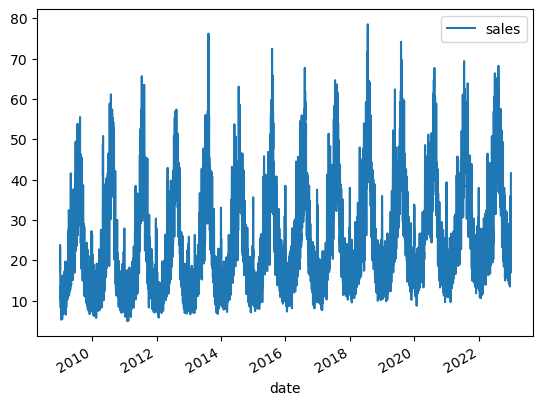

In [9]:
saless=df["sales"]
saless.plot()
#ヨコ軸のラベル
plt.legend()                                       #凡例表示
plt.show()

In [10]:
series=sales_np
series.shape

(4015,)

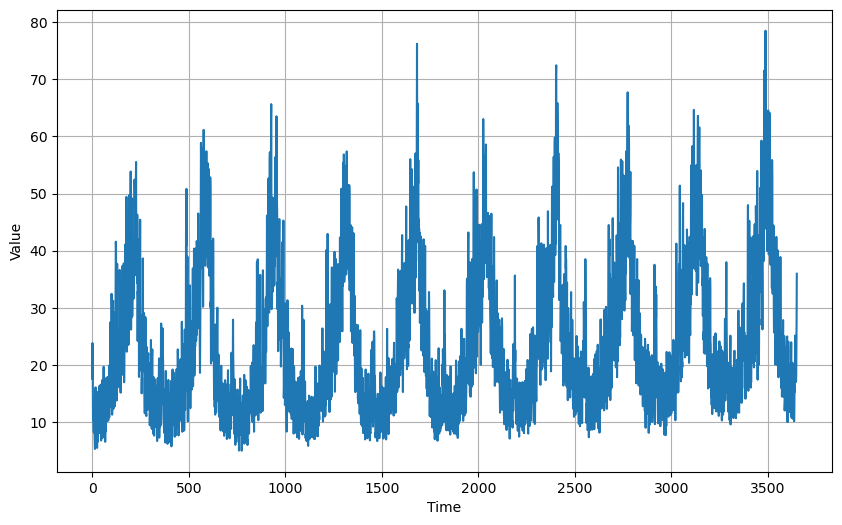

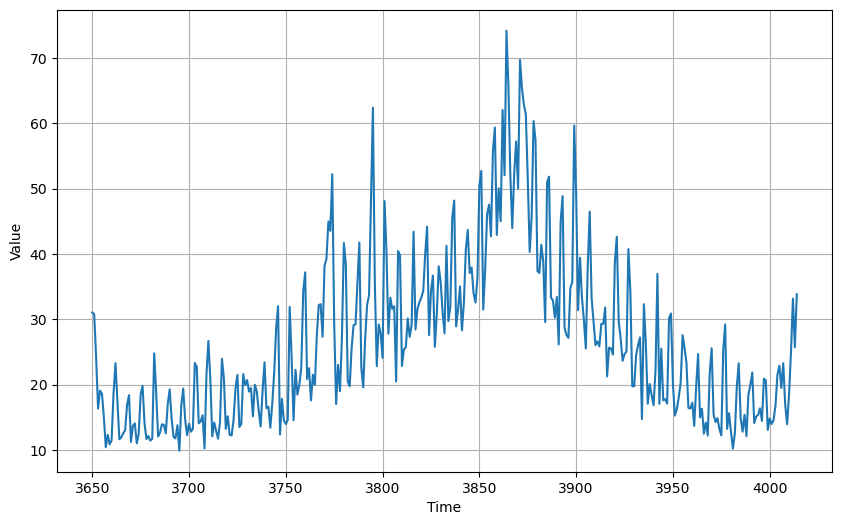

In [11]:
year=10
split_time = 365*year
time = np.arange(365*year+365, dtype="float32")

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


window_size = 32
batch_size = 256
shuffle_buffer_size = 4000

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train) # 学習セット
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid) # 検証セット
plt.show()

In [12]:
def windowing(df, window_size):
  x = []
  y = []

  for i in range(len(df) - window_size):
    x_result = df[i:i+window_size].to_list()
    x.append(x_result)
    y_result = df[i+window_size]
    y.append(y_result)

  return np.array(x), np.array(y)

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [14]:
x_train

array([17.59, 23.83, 22.94, ..., 22.93, 27.97, 35.97])

In [15]:
sales

date
2009-01-01    17.59
2009-01-02    23.83
2009-01-03    22.94
2009-01-04    17.14
2009-01-05    10.32
              ...  
2019-12-27    18.54
2019-12-28    24.99
2019-12-29    33.16
2019-12-30    25.73
2019-12-31    33.84
Name: sales, Length: 4015, dtype: float64

In [16]:
window_size = 20

x_train_lstm, y_train_lstm = windowing(sales_train, window_size)
x_test_lstm, y_test_lstm = windowing(sales_test,window_size)

In [17]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Bidirectional

# build lstm model
lstm_model = Sequential()
#lstm_model.add(tf.keras.layers.Bidirectional(LSTM(100, input_shape=(window_size, 1))))
#lstm_model.add(Dense(10))
lstm_model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(window_size,))))
#lstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
#lstm_model.add(Bidirectional(LSTM(32)))
#lstm_model.add(Dense(1))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
#lstm_model.add(LSTM(100, input_shape=[window_size, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.5))
#lstm_model.add(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.5, activation='relu')) 
#lstm_model.add(Dense(1))
#lstm_model.summary()

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, 
        verbose=1, mode='auto', restore_best_weights=True)

In [19]:
cp = ModelCheckpoint('model/', save_best_only=True)
lstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=RootMeanSquaredError())

In [20]:
# train lstm model
history = lstm_model.fit(tf.expand_dims(x_train_lstm, axis=-1), y_train_lstm, validation_data=(x_test_lstm, y_test_lstm), epochs=25, batch_size=32,verbose=1, callbacks=[cp])

Epoch 1/25
111/114 [============================>.] - ETA: 0s - loss: 229.5058 - root_mean_squared_error: 15.1494

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 9s 57ms/step - loss: 225.4943 - root_mean_squared_error: 15.0165 - val_loss: 51.2828 - val_root_mean_squared_error: 7.1612
Epoch 2/25
113/114 [============================>.] - ETA: 0s - loss: 40.2505 - root_mean_squared_error: 6.3443

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 6s 49ms/step - loss: 40.2270 - root_mean_squared_error: 6.3425 - val_loss: 42.9272 - val_root_mean_squared_error: 6.5519
Epoch 3/25
110/114 [===========================>..] - ETA: 0s - loss: 34.1911 - root_mean_squared_error: 5.8473

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 6s 54ms/step - loss: 34.1272 - root_mean_squared_error: 5.8419 - val_loss: 40.2177 - val_root_mean_squared_error: 6.3417
Epoch 4/25
114/114 [==============================] - ETA: 0s - loss: 32.3406 - root_mean_squared_error: 5.6869

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 6s 52ms/step - loss: 32.3406 - root_mean_squared_error: 5.6869 - val_loss: 37.2749 - val_root_mean_squared_error: 6.1053
Epoch 5/25
114/114 [==============================] - ETA: 0s - loss: 29.8258 - root_mean_squared_error: 5.4613

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 6s 50ms/step - loss: 29.8258 - root_mean_squared_error: 5.4613 - val_loss: 36.0408 - val_root_mean_squared_error: 6.0034
Epoch 6/25
112/114 [============================>.] - ETA: 0s - loss: 27.8163 - root_mean_squared_error: 5.2741

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 6s 52ms/step - loss: 28.0313 - root_mean_squared_error: 5.2945 - val_loss: 34.6265 - val_root_mean_squared_error: 5.8844
Epoch 7/25
112/114 [============================>.] - ETA: 0s - loss: 25.3109 - root_mean_squared_error: 5.0310

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 6s 55ms/step - loss: 25.3845 - root_mean_squared_error: 5.0383 - val_loss: 32.8060 - val_root_mean_squared_error: 5.7277
Epoch 8/25
110/114 [===========================>..] - ETA: 0s - loss: 24.5917 - root_mean_squared_error: 4.9590

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 6s 51ms/step - loss: 24.7056 - root_mean_squared_error: 4.9705 - val_loss: 31.4796 - val_root_mean_squared_error: 5.6107
Epoch 9/25
114/114 [==============================] - 2s 15ms/step - loss: 23.8719 - root_mean_squared_error: 4.8859 - val_loss: 32.2031 - val_root_mean_squared_error: 5.6748
Epoch 10/25
111/114 [============================>.] - ETA: 0s - loss: 23.2846 - root_mean_squared_error: 4.8254

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 6s 53ms/step - loss: 23.1343 - root_mean_squared_error: 4.8098 - val_loss: 31.1083 - val_root_mean_squared_error: 5.5775
Epoch 11/25
112/114 [============================>.] - ETA: 0s - loss: 22.7920 - root_mean_squared_error: 4.7741

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 6s 51ms/step - loss: 22.6909 - root_mean_squared_error: 4.7635 - val_loss: 30.6049 - val_root_mean_squared_error: 5.5322
Epoch 12/25
113/114 [============================>.] - ETA: 0s - loss: 22.2605 - root_mean_squared_error: 4.7181

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 6s 52ms/step - loss: 22.2501 - root_mean_squared_error: 4.7170 - val_loss: 29.9343 - val_root_mean_squared_error: 5.4712
Epoch 13/25
114/114 [==============================] - 2s 15ms/step - loss: 21.9236 - root_mean_squared_error: 4.6823 - val_loss: 30.9350 - val_root_mean_squared_error: 5.5619
Epoch 14/25
113/114 [============================>.] - ETA: 0s - loss: 21.9209 - root_mean_squared_error: 4.6820

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 6s 53ms/step - loss: 21.9377 - root_mean_squared_error: 4.6838 - val_loss: 29.9129 - val_root_mean_squared_error: 5.4693
Epoch 15/25
114/114 [==============================] - 2s 14ms/step - loss: 21.6384 - root_mean_squared_error: 4.6517 - val_loss: 30.3171 - val_root_mean_squared_error: 5.5061
Epoch 16/25
114/114 [==============================] - 2s 15ms/step - loss: 21.2393 - root_mean_squared_error: 4.6086 - val_loss: 30.1447 - val_root_mean_squared_error: 5.4904
Epoch 17/25
114/114 [==============================] - 2s 15ms/step - loss: 21.2003 - root_mean_squared_error: 4.6044 - val_loss: 30.2979 - val_root_mean_squared_error: 5.5043
Epoch 18/25
114/114 [==============================] - ETA: 0s - loss: 20.8015 - root_mean_squared_error: 4.5609

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 6s 51ms/step - loss: 20.8015 - root_mean_squared_error: 4.5609 - val_loss: 29.7030 - val_root_mean_squared_error: 5.4500
Epoch 19/25
114/114 [==============================] - 2s 15ms/step - loss: 20.7412 - root_mean_squared_error: 4.5543 - val_loss: 31.5257 - val_root_mean_squared_error: 5.6148
Epoch 20/25
114/114 [==============================] - 2s 13ms/step - loss: 20.5727 - root_mean_squared_error: 4.5357 - val_loss: 30.7981 - val_root_mean_squared_error: 5.5496
Epoch 21/25
114/114 [==============================] - 1s 13ms/step - loss: 20.0901 - root_mean_squared_error: 4.4822 - val_loss: 30.4634 - val_root_mean_squared_error: 5.5194
Epoch 22/25
114/114 [==============================] - 2s 13ms/step - loss: 19.9598 - root_mean_squared_error: 4.4676 - val_loss: 30.5318 - val_root_mean_squared_error: 5.5256
Epoch 23/25
114/114 [==============================] - 2s 13ms/step - loss: 19.9666 - root_mean_squared_error: 4.4684 - val_loss: 31

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 6s 53ms/step - loss: 19.9011 - root_mean_squared_error: 4.4611 - val_loss: 29.2802 - val_root_mean_squared_error: 5.4111
Epoch 25/25
114/114 [==============================] - 2s 14ms/step - loss: 19.7707 - root_mean_squared_error: 4.4464 - val_loss: 30.6591 - val_root_mean_squared_error: 5.5371


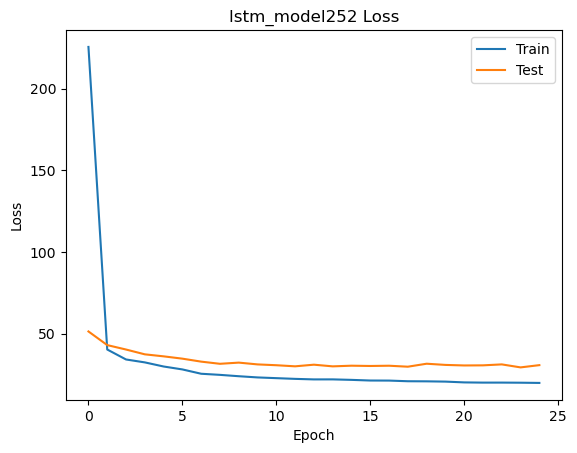

In [21]:
# plot train and test loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('lstm_model252 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [22]:
loss_df = pd.DataFrame({'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss = pd.DataFrame({'min': loss_df.min(), 'max': loss_df.max()})
loss
print(loss_df.min())

loss        19.770668
val_loss    29.280157
dtype: float64


In [23]:
# load lstm model
from tensorflow.keras.models import load_model
lstm_model = load_model('model/')

In [24]:
train_predictions = lstm_model.predict(x_train_lstm).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train_lstm})
train_results

114/114 [==============================] - 1s 5ms/step


,Train Predictions,Actuals
0,8.886794,7.12
1,6.805239,8.35
2,10.140307,10.68
3,15.591493,14.25
4,15.598697,15.30
...,...,...
3625,16.476761,17.04
3626,16.088259,18.28
3627,20.302912,22.93
3628,24.310059,27.97


In [26]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [27]:
forecast = model_forecast(lstm_model, series[split_time - window_size:-1], window_size)[:,0]

12/12 [==============================] - 2s 137ms/step


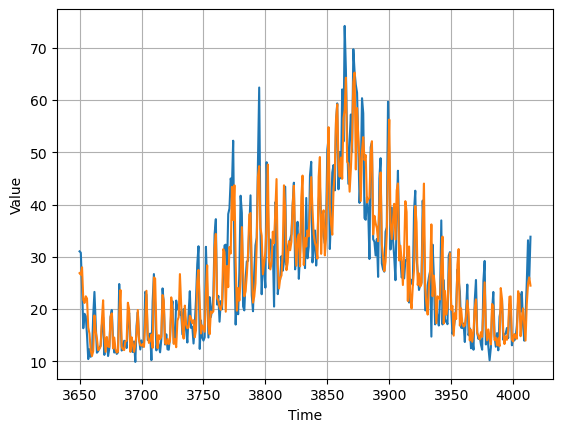

In [28]:
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [29]:
print('RMSE : ',np.sqrt(((x_valid - forecast)**2).mean()))
mae=mean_absolute_error(x_valid, forecast)
print('MAE : ',mae)

RMSE :  5.333628905527271
MAE :  3.8824051662079273
